<center><font size=6><b> 强化学习作业2代码题</b></font><center>
<center><br \><font size=4><b> 18300290007 加兴华</b></font><center>

### Q3
![image.png](https://s2.loli.net/2022/11/20/KSXmnPMlVAWfqyF.png)
由于lecture 4第21页没有图，我复现了lecture 3第21页。  
RM算法代码实现：

In [36]:
import numpy as np
import random
def RM(x0, h, noise_SD=0, alpha_type=1,steps=100):
    '''
    [Inputs]:
    x0              初始条件
    h               x=h(x)一式中的h函数
    noise_SD        高斯噪声标准差
    steps           迭代次数
    alpha_k         迭代步长类型(1:ak=1; 2:ak=1/k; 3:ak=1/k^2)
    [Outputs]:
    X               记录每次迭代x的列表
    '''
    X=[x0]
    alpha=[0]
    if alpha_type==1:
        alpha+=[1 for i in range(1,steps+1)]
    elif alpha_type==2:
        alpha+=[1/i for i in range(1,steps+1)]
    elif alpha_type==3:
        alpha+=[1/(i**2) for i in range(1,steps+1)]
    for i in range(1,steps+1):
        epsilon=np.random.randn()*noise_SD
        X.append(X[-1] + alpha[i] * (h(X[-1]) - X[-1]+epsilon))
    return X

题目：寻找$ f(x)=\tanh (x)-1 $ 的根，初值条件$x_1=3$

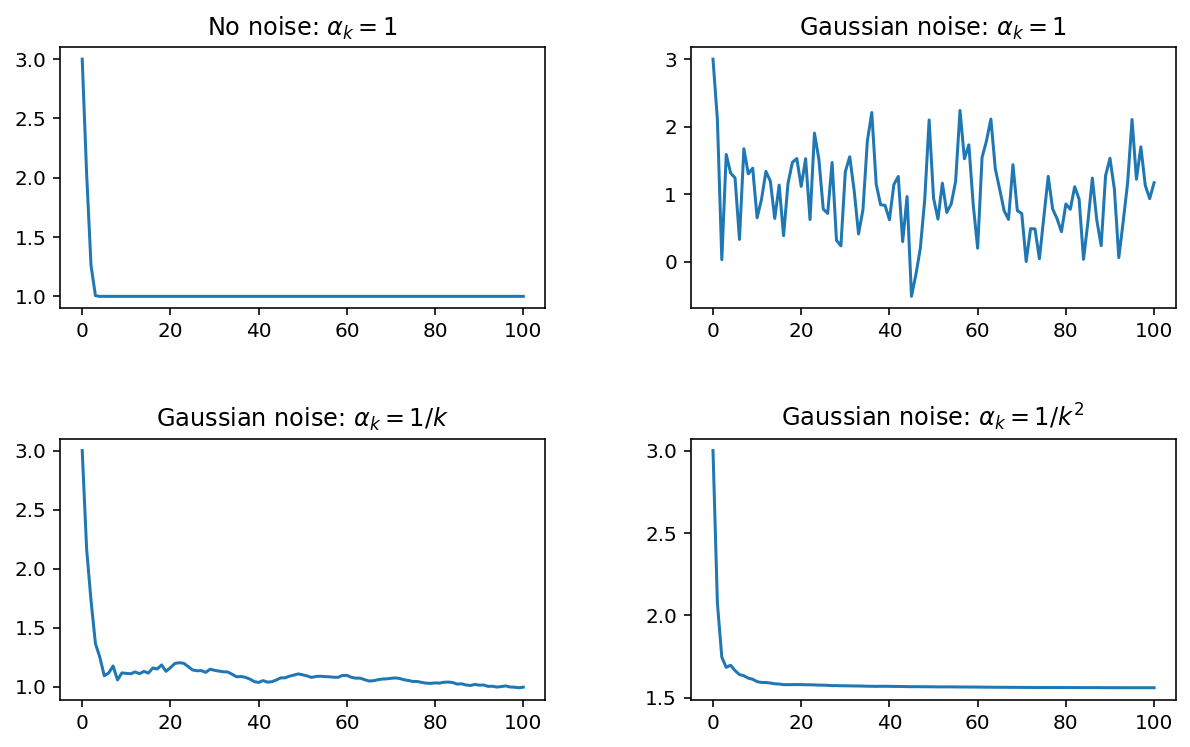

In [44]:
## Cell内打印图片
%matplotlib inline
## 设置显示标准维retina
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10,6))


## 设置模型
def h(x):
    return x - np.tanh(x-1)
x0=3

## 调用RM算法
n = np.arange(101)
x_case1 = RM(x0, h)
x_case2 = RM(x0, h, 0.5)
x_case3 = RM(x0, h, 0.5, 2)
x_case4 = RM(x0, h, 0.5, 3)


plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.5)
plt.subplot(2, 2, 1)
plt.plot(n, x_case1)
plt.title('No noise: $α_k= 1$')

plt.subplot(2, 2, 2)
plt.plot(n, x_case2)
plt.title('Gaussian noise: $α_k= 1$')

plt.subplot(2, 2, 3)
plt.plot(n, x_case3)
plt.title('Gaussian noise: $α_k= 1/k$')

plt.subplot(2, 2, 4)
plt.plot(n, x_case4)
plt.title('Gaussian noise: $α_k= 1/k^2$ ');

多次运行,观察发现前3张图与课件较为一致,但最后一张差异较大,我自己每次运行差异也较大,可能是步长衰减过快和高斯噪声波动性过大这两个因素组合导致的.

### Q5
![image.png](https://s2.loli.net/2022/11/20/Rj1HghAGetKw2um.png)
![image.png](https://s2.loli.net/2022/11/20/XfRgYeFtsuDVSk4.png)   
TD(0)评估阶段代码实现（为适配本题，我将采样过程从TD0算法中分离出来）

In [44]:
import random
def TD0_eval(samples,times=5, gamma=0.9):
    '''
    [Inputs]:
    samples         采样的轨迹列表
    times           重复TD0次数
    gamma           衰减系数
    samples
    [Outputs]:
    states          状态名列表
    values          状态值列表
    '''
    ## 统计出现过的状态名    
    ### 轨迹形如sarsarsars··· 因此每隔3个提取一次 
    states=[]
    for sample in samples:
        states+= sample[::3]
    states=sorted(list(set(states)))  ### 去除重复
    ## 生成状态的相关列表
    values=[0 for i in states] ### 状态值
    freqs=[0 for i in states]  ### 每个状态已经更新过的次数, 用于更新步长  
    ## 从轨迹列表中随机采样一条进行TD0更新
    for t in range(times):
        sample=random.choice(samples)
        for i in range(len(sample)):
            if sample[i] not in states: continue  ### 跳过非状态元素
            index=states.index(sample[i])
            freqs[index]+=1
            if i==len(sample)-1: continue   ### 跳过轨迹最后一个状态
            index_next_state=states.index(sample[i+3])
            alpha=1/freqs[index]
            values[index]+=alpha*(sample[i+2]+gamma*values[index_next_state]-values[index])
    return states,values

#### 1)

In [63]:
import pandas as pd
import numpy as np
times=50000
samples=[['A','a0',0,'B','a1',0,'A','a0',0,'B','a2',1,'T']]
states,values=TD0_eval(samples,times,0.1)
df = pd.DataFrame([values+[0.1,times]], columns = states+['衰减率','重复次数'])
for gamma in np.linspace(0.2, 0.9, 8):
    states,values=TD0_eval(samples,times,gamma)
    df.loc[len(df)]=values+[gamma,times]
df.style.hide(axis='index').format({'衰减率':'{:.1f}','重复次数':'{:.0f}'})

A,B,T,衰减率,重复次数
0.050247,0.502511,0.000000,0.1,50000
0.102028,0.510197,0.000000,0.2,50000
0.157033,0.523538,0.000000,0.3,50000
0.217298,0.543414,0.000000,0.4,50000
0.285467,0.571256,0.000000,0.5,50000
0.365199,0.609295,0.000000,0.6,50000
0.461823,0.661014,0.000000,0.7,50000
0.583471,0.731927,0.000000,0.8,50000
0.743060,0.830973,0.000000,0.9,50000


#### 2)

在不同的 $\gamma $ 下，$ V(A)\approx  \gamma *V(B) $ ;   
可以猜测收敛状态值有如下形式: $ V(B)=f(\gamma ), V(A)=f(\gamma )* \gamma  $

### Q6
![image.png](https://s2.loli.net/2022/11/20/YDIZlpAb268cKJX.png)
![image.png](https://s2.loli.net/2022/11/22/INL5pQm1FbfVA8P.png)

In [6]:
## 模型参数
### action坐标分解及名称列表
dx = [-1, 0, 1, 0, 0]
dy = [0, -1, 0, 1, 0]
acts = ['up  ', 'left', 'down', 'right', 'stay']
arrow= ['↑','←','↓','→','-']

### reward函数
H, W = (10, 10)
reward = np.zeros([H, W])
obstacles = [(4, 1), (6, 3), (1, 8), (6, 8), (8, 6)]
target = [(7, 6)]
for x, y in obstacles:
    reward[x, y] = -10
for x, y in target:
    reward[x, y] = 10

np.random.seed(10086)
random.seed(10086)

$\epsilon - greedy$ 版本代码实现   
![image.png](https://s2.loli.net/2022/11/22/9QZkNy7xrmPlY1G.png)
个人优化:   
假设轨迹长度>1000, $ \gamma =0.9$, 终点回报对于轨迹前面的Q(s,a)影响非常小, 反而更可能被障碍的惩罚影响, 因此不如采样更多次并舍弃特别长的轨迹.


In [65]:
import numpy as np
import random
import tqdm
def MC_egreedy(times=1000,gamma=0.9,threshold=500):
    '''
    [Inputs]:
    times           重复次数
    gamma           衰减率
    threshold       轨迹长度上限，超过就放弃本次采样
    [Outputs]:
    pi              策略矩阵
    Q               动作值3维矩阵
    '''
    ## 初始化相关矩阵 
    Q=np.zeros((len(acts),H,W))   ### |A|个块，每块H行W列
    N=np.zeros((len(acts),H,W))
    pi=np.random.randint(0,5,(H,W))  ### 泛化前的策略矩阵
    pi[np.array(target)[:,0],np.array(target)[:,1]]=4  ### 终点不动
    
    for k in tqdm.tqdm(range(times)):
        ## 采样轨道
        epsilon=0.3+0.2*np.cos(k/times*np.pi)
        s0=(random.randint(0, H-1), random.randint(0, W-1))
        episode=[s0]
        while episode[-1] not in target:
            if len(episode)>threshold: break
            s_now=episode[-1]
            ### 使用egreedy作为pi的beta变形
            if random.uniform(0, 1) < epsilon:  
                a=random.randint(0, 4)
            else:                               
                a=np.int8(pi[s_now])
            episode.append(a)
            s_next=(s_now[0]+dx[a],s_now[1]+dy[a])
            if not (0<=s_next[0]<=H-1 and 0<=s_next[1]<=W-1):
                s_next=s_now
                r=0
            else:
                r=reward[s_next]
            episode.append(r)
            episode.append(s_next)
        
        # print(episode,'\n')

        ## 更新
        if len(episode)>threshold: continue
        if len(episode)==1: continue
        state=episode[-4:0:-3]
        r=episode[-2:2:-3]
        a=episode[-3:1:-3]
        G = 0
        for t in range(0,len(state)):
            G=gamma*G+r[t]
            x,y=state[t][0],state[t][1]
            if (state[t],a[t]) in zip(state[t+1:],a[t+1:]): continue
            N[a[t],x,y]+=1
            Q[a[t],x,y]+=(G-Q[a[t],x,y])/N[a[t],x,y]
            if Q[a[t],x,y] > Q[int(pi[x,y]),x,y]:
                pi[x,y] = a[t]
    return pi,Q
pi,_=MC_egreedy(100000,0.9,10000)
for i in range(H):
    for j in range(W):
        print(arrow[np.int8(pi[i,j])], end=' ')
    print('')

100%|██████████| 100000/100000 [00:06<00:00, 14557.15it/s]

→ ↓ → ↓ ↓ ↓ ↓ ← ← ↓ 
→ → → ↓ ↓ ↓ ↓ ← ↓ ↓ 
→ → → → ↓ ↓ ↓ ↓ ↓ ↓ 
↑ → → → → ↓ ↓ ↓ ← ↓ 
↓ ↓ → → → ↓ ↓ ↓ ← ← 
↓ ↓ → → → ↓ ↓ ← ← ↑ 
↓ ↓ ↓ ↓ → → ↓ ← ← ↓ 
→ → → → → → - ← ← ← 
→ → → → ↑ ↑ ↑ ↑ ← ← 
→ → → → ↑ ↑ ← ↑ ← ← 


Off-policy 版本代码实现
![image.png](https://s2.loli.net/2022/11/22/akRVMFroSpEXfAO.png)

In [7]:
import numpy as np
import random
import tqdm
def MC_offpolicy(times=1000,gamma=0.9,threshold=500):
    '''
    [Inputs]:
    times           重复次数
    gamma           衰减率
    threshold       轨迹长度上限，超过就放弃本次采样
    [Outputs]:
    pi              策略矩阵
    Q               动作值3维矩阵
    
    '''
    ## 初始化相关矩阵 
    Q=np.zeros((len(acts),H,W))   ### |A|个块，每块H行W列
    N=np.zeros((len(acts),H,W))
    pi=np.random.randint(0,5,(H,W))  ### 泛化前的策略矩阵
    pi[np.array(target)[:,0],np.array(target)[:,1]]=4  ### 终点不动
    
    for k in tqdm.tqdm(range(times)):
        ## 采样轨道
        epsilon=0.3+0.2*np.cos(k/times*np.pi)
        s0=(random.randint(0, H-1), random.randint(0, W-1))
        episode=[s0]
        while episode[-1] not in target:
            if len(episode)>threshold: break
            s_now=episode[-1]
            if random.uniform(0, 1) < epsilon:  ### explore
                a=random.randint(0, 4)
            else:                               ### exploit
                a=np.int8(pi[s_now])
            episode.append(a)
            s_next=(s_now[0]+dx[a],s_now[1]+dy[a])
            if not (0<=s_next[0]<=H-1 and 0<s_next[1]<=W-1):
                s_next=s_now
                r=0
            else:
                r=reward[s_next]
            episode.append(r)
            episode.append(s_next)
        
        # print(episode,'\n')

        ## 更新
        if len(episode)>threshold: continue
        if len(episode)==1: continue
        state=episode[-4:0:-3]
        r=episode[-2:2:-3]
        a=episode[-3:1:-3]
        G = 0
        w = 1
        for t in range(0,len(state)):
            Echoes=pi[state[t]]
            G=gamma*G+r[t]
            x,y=state[t][0],state[t][1]
            if (state[t],a[t]) not in zip(state[t+1:],a[t+1:]):
                N[a[t],x,y]+=1
                Q[a[t],x,y]+=(w*G-Q[a[t],x,y])/N[a[t],x,y]
                if Q[a[t],x,y] > Q[int(pi[x,y]),x,y]:
                    pi[x,y] = a[t]
            if a[t] == Echoes:
                w /= 1 - epsilon * 0.8    ### 概率比=1-epsilon(1-1/|A|)
            else:
                w *= 0
    return pi,Q
pi,_=MC_offpolicy(100000,0.9,10000)
for i in range(H):
    for j in range(W):
        print(arrow[np.int8(pi[i,j])], end=' ')
    print('')

100%|██████████| 100000/100000 [00:10<00:00, 9891.29it/s]

→ ↓ ↓ → ↓ → → ↓ ← ↓ 
→ → ↓ ↓ ↓ → ↓ ↓ ↓ ↓ 
→ → ↓ → → → ↓ ← ↓ ↓ 
→ → → ↓ → → ↓ ← ← ← 
← ↓ ↓ → ↓ ↓ ↓ ← ← ← 
→ → ↓ → → ↓ ↓ ↓ ← ↓ 
→ ↑ ↓ ↓ ↓ → ↓ ← ← ↓ 
→ → → → → → - ← ← ← 
→ ↑ ↑ → → ↑ ↑ ↑ ↑ ↑ 
→ ↑ ↑ → ↑ ↑ ← ↑ ← ↑ 


设置重复采样100000次、衰减率0.9、舍弃长度大于10000的轨迹，两种算法的结果如输出所示，可以发现MC算法受限于采样随机性，选择的行动可能不是最优的，但是一定不会选择最差的，表现为动作总是绕过障碍。